In [2]:
# create a model that uses the fenchel-young loss and trains on 200 images 
# the images are permuted in 9 tiles and in every iteration a new permutation is generated.
# we use a deep encoder with fixed parameters, adam optimizer, preprocessing before tiling  

import tensorflow as tf

In [3]:
import platform
import cv2
import numpy as np
import os
from pathlib import Path

number_of_images = 200

root = os.getcwd() # Don't change this
data_dirname = '/data_test/plantvillage/' # Change as you like 
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) 
if platform.system()=='Darwin':
  root = os.getcwd() # Don't change this
  data_dirname = '/data_test/plantvillage/' # Change as you like 
  p = Path(root + data_dirname)
  p.mkdir(exist_ok=True) 
else:
  p = Path("C:/Users/mwels/Documents/Uni/11. Semester/Deep learning in visual recognition/Plant_leave_diseases_dataset_without_augmentation")
  p.mkdir(exist_ok=True)


classes = [
  'Apple___Apple_scab',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  "all"
  ]

if "all" in classes:
  classes = os.listdir(p)

for c in classes:
  print(c,end=" ")
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))


filelist = filelist[:number_of_images]
print(len(filelist))

Apple___Apple_scab Apple___Black_rot Apple___Cedar_apple_rust Apple___healthy Background_without_leaves Blueberry___healthy Cherry___healthy Cherry___Powdery_mildew Corn___Cercospora_leaf_spot Gray_leaf_spot Corn___Common_rust Corn___healthy Corn___Northern_Leaf_Blight Grape___Black_rot Grape___Esca_(Black_Measles) Grape___healthy Grape___Leaf_blight_(Isariopsis_Leaf_Spot) Orange___Haunglongbing_(Citrus_greening) Peach___Bacterial_spot Peach___healthy Pepper,_bell___Bacterial_spot Pepper,_bell___healthy Potato___Early_blight Potato___healthy Potato___Late_blight Raspberry___healthy Soybean___healthy Squash___Powdery_mildew Strawberry___healthy Strawberry___Leaf_scorch Tomato___Bacterial_spot Tomato___Early_blight Tomato___healthy Tomato___Late_blight Tomato___Leaf_Mold Tomato___Septoria_leaf_spot Tomato___Spider_mites Two-spotted_spider_mite Tomato___Target_Spot Tomato___Tomato_mosaic_virus Tomato___Tomato_Yellow_Leaf_Curl_Virus 200


In [4]:
len(filelist)

200

In [5]:
tilex = 3
number_of_tiles = tilex**2
tile_size = 255//tilex

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(tile_size, tile_size, 3))

In [18]:
from keras.layers import Dense, Concatenate, Input, Flatten, Lambda 
from keras.models import Model
import os


tiles = Input((number_of_tiles,tile_size,tile_size,3))
layers = {}
embedds = {}

shared_conv = conv_base 

for i in range(number_of_tiles):
    layers[f'tile{i}'] = Lambda(lambda x: x[:,i,:,:,:])(tiles)

    layers[f'deep_layers{i}'] = shared_conv(layers[f'tile{i}'])
    embedds[f'embedd{i}'] = Flatten()(layers[f'deep_layers{i}'])

concatonation = Concatenate(axis=1)(list(embedds.values()))

out = Dense(number_of_tiles*10, activation="relu", kernel_initializer='he_normal')(concatonation)
out = Dense(number_of_tiles, kernel_initializer='he_normal')(out)
out = Flatten()(out)

model = Model(inputs=tiles, outputs=out)

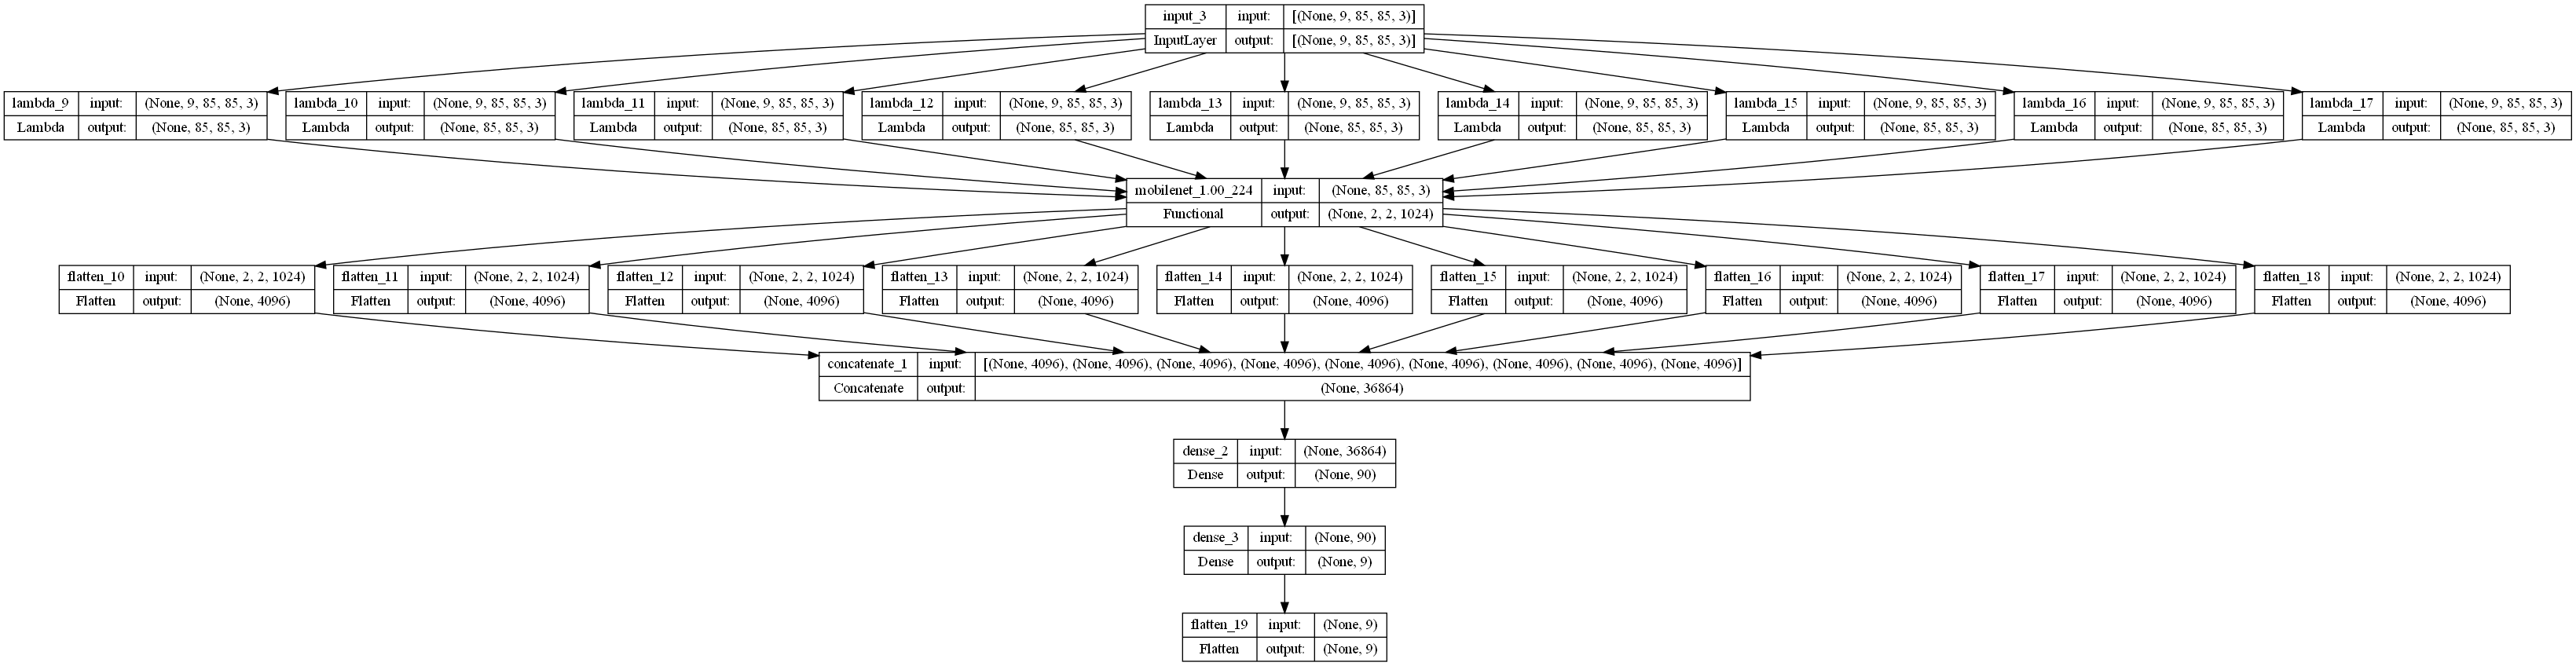

In [19]:
tf.keras.utils.plot_model(model, 
    show_shapes=True)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 9, 85, 85,   0           []                               
                                3)]                                                               
                                                                                                  
 lambda_9 (Lambda)              (None, 85, 85, 3)    0           ['input_3[0][0]']                
                                                                                                  
 lambda_10 (Lambda)             (None, 85, 85, 3)    0           ['input_3[0][0]']                
                                                                                                  
 lambda_11 (Lambda)             (None, 85, 85, 3)    0           ['input_3[0][0]']          

In [12]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 24
Number of pretrained base layers is 86


In [22]:
sys.path.append('src')

In [30]:
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.PermOneHotDataGen import *
from src.model_tools import *

x_train, x_test = train_test_split(filelist)

train_generator = PermOneHotDataGen(x_train,
                                    batch_size=8,
                                    tilenumberx=tilex, 
                                    shuffle_permutations=True)

validation_generator = PermOneHotDataGen(x_test,
                                        batch_size=8,
                                        tilenumberx=tilex,
                                        shuffle_permutations=False)


optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)


model.compile(
    optimizer=optimizer,
    loss=RankingLoss(),
    metrics=[ProjectedRanksAccuracy(), PartialRanksAccuracy()])

AssertionError: Duplicate registrations for type 'trackable_dict_wrapper'

'2.10.0'